# Team *Memento Mori* - be mindful of death!

In this project, we plan to analyze CDC Data to predict the likelihood of an individual dying from a natural cause or an unnatural cause.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_style('whitegrid')

In [2]:
## Import the data
### Codes
json2015 = pd.read_json('2015_codes.json')

### Data
df2015 = pd.read_csv('2015_data.csv')

/Users/christiancofoid/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (40,41,42,43,61,62,63,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
## Take a sample from the data so that we aren't lugging around a 1.6gB array
df_sample = df2015.sample(frac = 0.1, random_state = 33)

List the columns of the DataFrame `df2015`.

In [ ]:
df_sample.info()

## Natural/Unnatural encoding

We now encode the deaths which we rule unnatural.  By an **unnatural death**, we mean a death which is caused by one of the following causes:
1. Accident: 
    1. unintentional injuries
    2. transportation
    3. motor vehicle, land/water/air/space
    4. nontransport accidents
    5. Falls
    6. Accidental discharge of firearms
    7. Accidental drowning
    8. Accidental exposure to smoke, fire, flames
    9. Accidental poisoning
2. Homicide:
    1. Assault, not by the below causes
    2. Assault with firearms
    3. Assault with unspecified means
3. Suicide:
    1. Suicide by means other than the causes below
    2. Suicide by discharge of firearm
    3. Suidice by unspecified means
4. Execution
5. Undetermined intent
    1. U.I. except those listed below
    2. Discharge of firearms, undetermined intent
    3. Other
6. Operations of war
7. Complications from medical and surgical care

These correspond to cause of death codes 112-135 in the feature `113_cause_recode`.

In [4]:
#obtain these codes from the 2015 json file
causes_113 = json2015[json2015['113_cause_recode'].isnull() == False]['113_cause_recode']
causes_113.index = list(map(int,causes_113.index))
causes_113.name = '113_cause_recode_json'

#extract unnatural causes labels
unnatural_causes = causes_113.index[111:]
# df_sample['113_cause_recode']

Now label each instance as a natural -- $0$ -- or unnatural -- $1$ -- death.

In [5]:
# def class_label(row):
#     if row['113_cause_recode'] in unnatural_causes:
#         row['unnatural'] = 1
#     else:
#         row['unnatural'] = 0
#     return row

df_sample['unnatural'] = 0
df_sample[(df_sample['113_cause_recode']<= max(unnatural_causes))
          & (df_sample['113_cause_recode']>= min(unnatural_causes))] = 1

In [ ]:
# df_sample = df_sample.copy().apply(lambda x: class_label(x), axis = 1)

##  EDA: Univariate and Bivariate
### `113_cause_recode`

Let us examine the distribution of causes according to the feature `113_cause_recode`, broken up into different plots by the the feature `unnatural`.

In [8]:
##how many features are in the unnatural deaths 
# unnatural_num = len(np.where(df_sample['113_cause_recode'].unique() >= 112)[0])

In [10]:
# fig, ax = plt.subplots(1,2,figsize = (8,4))

# sns.histplot(data = df_sample[df_sample['unnatural'] == 0], 
#             x = '113_cause_recode',
#             bins = 114-unnatural_num, 
#             stat = 'probability',
#              hue = 'sex',
#              hue_order = ['F','M'],
#             ax = ax[0]);
# ax[0].set_title('Natural Causes, by sex')

# sns.histplot(data = df_sample[df_sample['unnatural'] == 1],
#             x = '113_cause_recode',
#             bins = 18,
#             stat = 'probability',
#             hue_order = ['F','M'],
#              hue = 'sex',
#             ax = ax[1]);
# ax[1].set_title('Unnatural Causes, by sex')
# fig.tight_layout()

Unnatural deaths are much more prevalent across all such causes amongst Males than Females.

By marital status:

In [11]:
# fig, ax = plt.subplots(1,2,figsize = (8,4))

# sns.histplot(data = df_sample[df_sample['unnatural'] == 0], 
#             x = '113_cause_recode',
#             bins = 114-unnatural_num, 
#             stat = 'probability',
#              hue = 'marital_status',
# #              hue_order = ['F','M'],
#             ax = ax[0]);
# ax[0].set_title('Natural Causes, by marital status')

# sns.histplot(data = df_sample[df_sample['unnatural'] == 1],
#             x = '113_cause_recode',
#             bins = 18,
#             stat = 'probability',
# #             hue_order = ['F','M'],
#              hue = 'marital_status',
#             ax = ax[1]);
# ax[1].set_title('Unnatural Causes, by marital status')
# fig.tight_layout()

## `education`: cleaning the 1989_recoding problem

In the feature `education_revision_2003` some of the instances are using a 1989 code, and these are the codes which are `nan` values.  Unstated education levels are encoded with a `99`.  The `nan` value in `education_revision_2003` is indicated with a 0 in the `education_reporting_flag` feature.  We use the feature `education_reporting_flag` to create a new feature, `education` which return the 2003 education revision and updates the instances which use the 1989 revision.  Values of `9`, which are unreported, are retained.

In [12]:
def education_clean(row):
    if row['education_reporting_flag'] == 0:
        revis_1989 = row['education_1989_revision']
        
        # need to reclassify based on the 2003 education revision
        if 0<= revis_1989 <= 8:
            row['education'] = 1
        elif 9<= revis_1989 <=11:
            row['education'] = 2
        elif revis_1989 == 12:
            row['education'] = 3
        elif revis_1989 == 13:
            row['education'] = 4
        elif 14<= revis_1989 <= 15:
            row['education'] = 5
        elif revis_1989 == 16:
            row['education'] = 6
        elif revis_1989 == 17: #some fudging is going on here -- not sure if >=5 years of college corresponds
                                # to a Master's degree or PhD/Professional degree...
            row['education'] = 7
        elif revis_1989 == 99:
            row['education'] = 9
            
    elif row['education_reporting_flag'] == 1:
        row['education'] = int(row['education_2003_revision'])
     
    return row

In [13]:
df_sample = df_sample.apply(education_clean, axis = 1)

In [14]:
# We are missing about 4.5% of the education data -- use a simple imputer?
df_sample[df_sample.education == 9].shape[0]/df_sample.shape[0]

0.041785004782576705

Let us examine the distribution of the feature `education`, splitting into two plots based on `unnatural`.  
- The feature `education` is an ordinal variable, since it measures the amount of formal education the decedent has received.
- 


In [15]:
# fig, ax = plt.subplots(1,2,figsize = (8,4))

# sns.histplot(data = df_sample[(df_sample['unnatural'] == 0) & (df_sample['education'] < 9)], 
#             x = 'education',
#             bins = np.arange(1,10)-0.5,
#             stat = 'probability',
#              hue = 'sex',
#             hue_order = ['F','M'],
#             ax = ax[0]);
# ax[0].set_title('Natural Causes')
# ax[0].set_xticks(range(1,9))

# sns.histplot(data = df_sample[(df_sample['unnatural'] == 1) & (df_sample['education'] < 9)],
#             x = 'education',
#             bins = np.arange(1,10)-0.5,
#             stat = 'probability',
#              hue = 'sex',
#              hue_order = ['F','M'],
#             ax = ax[1]);
# ax[1].set_title('Unnatural Causes')
# ax[1].set_xticks(range(1,9))
# fig.tight_layout()

By marital status:

In [16]:
# fig, ax = plt.subplots(1,2,figsize = (8,4))

# sns.histplot(data = df_sample[(df_sample['unnatural'] == 0) & (df_sample['education'] < 9)], 
#             x = 'education',
#             bins = np.arange(1,10)-0.5,
#             stat = 'probability',
#              hue = 'marital_status',
#              hatch = ''
#              ax = ax[0]);
# ax[0].set_title('Natural Causes')
# ax[0].set_xticks(range(1,9))

# sns.histplot(data = df_sample[(df_sample['unnatural'] == 1) & (df_sample['education'] < 9)],
#             x = 'education',
#             bins = np.arange(1,10)-0.5,
#             stat = 'probability',
#              hue = 'marital_status',
#             ax = ax[1]);
# ax[1].set_title('Unnatural Causes')
# ax[1].set_xticks(range(1,9))
# fig.tight_layout()

This isn't telling me anything new from what I know from the distribution of `age`.

## `age`
There needs to be some cleaning of the data to determine the age of the decedent, particularly in the case of the death of an infant.  I'm not sure what's going on with the feature `detail_age` or if that has been condensed down to an integer representing number of years lived.  

Note that ages which are missing are encoded as 999.  There aren't many, so we can just fill them with the median age for the particular value of `sex`.

In [ ]:
df_sample.loc[df_sample.detail_age == 999].shape[0]

In [ ]:
M_med_age = df_sample[(df_sample.detail_age != 999) & (df_sample.sex == "M")].detail_age.median()
F_med_age = df_sample[(df_sample.detail_age != 999) & (df_sample.sex == "F")].detail_age.median()

df_sample[(df_sample.detail_age == 999) & (df_sample.sex == "M")] = M_med_age
df_sample[(df_sample.detail_age == 999) & (df_sample.sex == "F")] = F_med_age

# def fill_missing_age(row):
#     if row['detail_age'] == 999:
#         if row['sex'] == 'M':
#             row['detail_age'] = M_med_age
#         if row['sex'] == 'F':
#             row['detail_age'] = F_med_age
#     return row

In [ ]:
# df_sample = df_sample.copy().apply(fill_missing_age, axis = 1)

In [ ]:
df_sample.loc[df_sample.detail_age == 1,['detail_age','age_recode_52']]

The number of instances when the age is recorded as 1, but the child died between the time of birth and the age of 1 is tiny compared to the number of observations: about $0.25\%$ of the instances correspond to this scenario.

In [ ]:
df_sample.detail_age.max()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))

#first plot is of the age distribution of natural deaths
# drop the values of 999, which are missing
sns.histplot(data = df_sample[(df_sample.detail_age != 999)&(df_sample.unnatural == 0)],
            x = 'detail_age',
            ax = ax[0],
            hue = 'sex',
             stat = 'probability',
             hue_order = ['F','M'],
            bins = np.arange(1,df_sample.detail_age[df_sample.detail_age < 999].max()))
ax[0].set_title('Age of natural deaths,\ncolored by sex of decedent')
ax[0].set_xticks(range(0,115,10))

#second plot is of the age distribution of unnatural deaths
# drop the values of 999, which are missing
sns.histplot(data = df_sample[(df_sample.detail_age != 999)&(df_sample.unnatural == 1)],
            x = 'detail_age',
            ax = ax[1],
            hue = 'sex',
             stat = 'probability',
             hue_order = ["F","M"],
            bins = np.arange(1,df_sample.detail_age[df_sample.detail_age < 999].max()))
ax[1].set_title('Age of unnatural deaths,\ncolored by sex of decedent')
ax[1].set_xticks(range(0,115,10))
fig.tight_layout()

Note the difference in the $y$-scales.

It looks like there is a considerable difference in the distribution of `detailed_age` based on whether or not the death was natural.  Moreover, the `sex` of the decedent changes the distribution of the age unnatural deaths considerably.

In [ ]:
from scipy.stats import kurtosis

In [ ]:
df_sample.groupby(by = ['unnatural','sex']).agg({"detail_age":[np.mean,np.median,np.std,kurtosis]})

In [ ]:
from scipy.stats import kurtosistest

In [ ]:
kurtosistest(df_sample[df_sample.unnatural == 1].detail_age)

Yes, the above test confirms that these data are certainly NOT normally distributed.

Let's look at the distribution of `detail_age` segmented by `marital_status`.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))

#first plot is of the age distribution of natural deaths
sns.histplot(data = df_sample[(df_sample.unnatural == 0)],
            x = 'detail_age',
            ax = ax[0],
            hue = 'marital_status',
             hue_order = ['W','M','S','D','U'],
             stat = 'probability',
            bins = np.arange(1,df_sample.detail_age.max()))
ax[0].set_title('Age of natural deaths,\ncolored by matrial status of decedent')
ax[0].set_xticks(range(0,115,10))

#second plot is of the age distribution of unnatural deaths
sns.histplot(data = df_sample[(df_sample.unnatural == 1)],
            x = 'detail_age',
            ax = ax[1],
            hue = 'marital_status',
             hue_order = ['W','M','S','D','U'],
             stat = 'probability',
            bins = np.arange(1,df_sample.detail_age.max()))
ax[1].set_title('Age of unnatural deaths,\ncolored by marital status of decedent')
ax[1].set_xticks(range(0,115,10))
fig.tight_layout()

Natural deaths occur more frequently later in life for married decedents (M) or widow/widower decedents (W).  Single decedents (S) have a much higher probability of dying due to an unnatural than a natural cause at an early age.  It is interesting to note that the distribution of age for married decedents from unnatural causes looks quite symmetric, as does the distribution for divorced due to unnatural causes.

## `manner_of_death`

In [ ]:
(df_sample.index.shape[0] - df_sample.manner_of_death.value_counts().sum())/df_sample.index.shape[0]

About 14% of the instances are missing data for `manner_of_death`.  Our classification takes care of that issue.

## `place_of_injury_for_causes_w00_y34_except_y06_and_y07_`

These are the places of unjury for accidental deaths


In [ ]:
fig, ax = plt.subplots(1,1,figsize = (6,3))

ax.bar(x =df_sample['place_of_injury_for_causes_w00_y34_except_y06_and_y07_'].value_counts().sort_index().index,
      height = df_sample['place_of_injury_for_causes_w00_y34_except_y06_and_y07_'].value_counts().sort_index().values,
      alpha = 0.75)
ax.set_xlabel('Place of Injury', fontsize = 12)
ax.set_ylabel('Count', fontsize = 12)
ax.set_xticks(np.arange(0,10));
fig.tight_layout()

df_sample['place_of_injury_for_causes_w00_y34_except_y06_and_y07_'].value_counts().sort_index()
print("Percentage of non-null values for this feature: {:0.4f}%.".format(
    100*df_sample['place_of_injury_for_causes_w00_y34_except_y06_and_y07_'].value_counts().sum()/df_sample.shape[0]))

However, most of the instances are missing data for this feature: there is only a little more than 7.6% of the data which has non null values.  I don't think it is a good decision to fill in over 90% of the data with the median for this feature -- best to not use it.

## `place_of_death_and_decedents_status`

In [ ]:
df_sample.place_of_death_and_decedents_status.unique()

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (8,4))

sns.histplot(data = df_sample[df_sample.unnatural == 0],
      x = 'place_of_death_and_decedents_status',
      hue = 'sex',
             hue_order = ['F',"M"],
            ax = ax[0],
            bins = np.arange(1,10)-0.5)

ax[0].set_title('Place of death, natural, by sex')
sns.histplot(data = df_sample[df_sample.unnatural == 1],
      x = 'place_of_death_and_decedents_status',
      hue = 'sex',
             hue_order = ['F',"M"],
            ax = ax[1],
            bins = np.arange(1,10)-0.5)

ax[1].set_title('Place of death, unnatural, by sex')
# ax.set_xlabel('Place of Injury', fontsize = 12)
# ax.set_ylabel('Count', fontsize = 12)
# ax.set_xticks(np.arange(0,10));
fig.tight_layout()

Comments:
1. Women: exceeded men in death in nursing homes, hospice, or other, for natural deaths, and in nursing homes for unnatural deaths.

## `race`

Do some aggregation on `df_sample` to compute probability of unnatural death for each race.

In [ ]:
race_dct = {key: val for key, val in zip(sorted(df_sample.race.unique()),
    ["White","Black", "American Indian", "Chinese",
     "Japanese", "Hawaiian", "Filipino","Asian Indian",
     "Korean", "Samoan", "Vietnamese", "Guamanian",
     "Other Asian\nor P.I.","Combined \no. Asian or P.I."])}

unnat_by_race = df_sample.groupby('race').agg({"unnatural":[np.sum, len]})['unnatural']
unnat_by_race.loc[:,"cond_rel_freq"]= unnat_by_race['sum']/unnat_by_race['len']
def assign_race(row):
    row['Race'] = race_dct[row.name]
    return row
unnat_by_race = unnat_by_race.copy().apply(assign_race, axis = 1)
unnat_by_race.columns = ['unnatural_deaths','total_deaths', 'cond_rel_freq','race']

In [ ]:
unnat_by_race

Let $R$ be the random variable indicating a decedent's race, and $U$ be the random variable indicating the type of death (unnatural = 1, natural = 0).  We plot the distribution $P(U = 1|R = r)$ for each race $r\in \mathtt{race\underline{\,\,\,}dct.values}$.

In [ ]:
fig, ax = plt.subplots(2,1,figsize = (8,8))

ax[0].bar(x = unnat_by_race.race,
      height= unnat_by_race.cond_rel_freq,
      alpha = 0.7)
ax[0].set_ylabel('$P(U = 1|R = r)$')
ax[0].set_xticklabels(unnat_by_race.race, rotation = 70)
ax[0].set_title('Probability of unnatural death, by race')

ax[1].bar(x = unnat_by_race.race,
          height = np.log10(unnat_by_race.total_deaths),
          alpha = 0.7
         )
ax[1].set_ylabel('$\log(\mathtt{count})$')
ax[1].set_xticklabels(unnat_by_race.race, rotation = 70)
ax[1].set_title('Log deaths by unnatural causes, by race')
fig.tight_layout()

## Baseline Model: take the sample average.

Classify $100\hat{p}\% \approx 7.96\%$ of instances as unnatural.

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import recall_score, precision_score

In [ ]:
# n_splits = 10

# kfold = StratifiedKFold(n_splits = n_splits, 
#                        shuffle = True,
#                        random_state = 33)

# baseline_recs_precs = np.zeros((n_splits,2))

In [ ]:
# i = 0
# for train_ix, test_ix in kfold.split(df_sample, df_sample.unnatural):
#     df_tt, df_ho = df_sample.iloc[train_ix], df_sample.iloc[test_ix]
    
#     hat_p = df_tt.unnatural.sum()/df_tt.shape[0]
#     pred = [np.random.binomial(n = 1, p = hat_p) for j in range(df_ho.shape[0])]
#     rec = recall_score(y_true= df_ho.unnatural.values,
#                       y_pred = pred)
#     prec = precision_score(y_true= df_ho.unnatural.values,
#                       y_pred = pred)
    
#     baseline_recs_precs[i,0] = rec
#     baseline_recs_precs[i,1] = prec
#     i += 1


In [ ]:
# baseline_recs_precs.mean(axis = 0)
# print("Baseline recall:    {:0.4f}\nBaseline precision: {:0.4f}".format(baseline_recs_precs.mean(axis = 0)[0],
#                                                                       baseline_recs_precs.mean(axis = 0)[1]))

I think we can construct a better baseline model than this.  Let's try a logisitc regression with the following features:

In [ ]:
# # def cat_encoder(row):
# #     dct = {"sex":{"M":1,"F":0},
# #           "marital_status":{"W":1,"M":2, "S":3, "D":4 ,"U":5}}
# #     row['encode_sex'] = dct['sex'][row['sex']]
# #     row['encode_ms'] = dct['marital_status'][row['marital_status']]
# #     return row
# df_dummies_MF = pd.get_dummies(df_sample['sex'])
# df_dummies_MF.columns = ['sex_M','sex_F']

# df_dummies_MS = pd.get_dummies(df_sample['marital_status'])
# df_dummies_MS.columns = ['marital_status_{}'.format(c) for c in df_dummies_MS.copy().columns]

# df_sample = pd.merge(df_sample.copy(), df_dummies_MF,
#                     how = 'inner',
#                     left_index = True,
#                     right_index = True)
# df_sample = pd.merge(df_sample.copy(), df_dummies_MS,
#                     how = 'inner',
#                     left_index = True,
#                     right_index = True)

In [ ]:
# #Take the columns we're going to use
# df_touse = df_sample[['unnatural','detail_age','education'] + list(df_sample.columns[-7:])]

# #Now encode the interactions
# ms_cols = df_touse.columns[-5:]
# MF_cols = ['sex_M','sex_F']

# for col in ms_cols:
#     df_touse.loc[:,"education_{}".format(col)] = df_touse.copy()['education'] * df_touse.copy()[col]
#     df_touse.loc[:,"detail_age_{}".format(col)] = df_touse.copy()['detail_age'] * df_touse.copy()[col]
# for col in MF_cols:
#     df_touse.loc[:,"education_{}".format(col)] = df_touse.copy()['education'] * df_touse.copy()[col]
#     df_touse.loc[:,"detail_age_{}".format(col)] = df_touse.copy()['detail_age'] * df_touse.copy()[col]

In [ ]:
# df_touse.head()
# age_cols = [col for col in df_touse.columns if 'detail_age' in col]

In [ ]:
# from sklearn.preprocessing import StandardScaler
# SS = StandardScaler()
# SS.fit_transform(test)
# SS.feature_names_in_

In [ ]:

# # I need to make a scaler for the features involving age.

# from sklearn.preprocessing import StandardScaler
# from sklearn.base import BaseEstimator, TransformerMixin


# class AgeScaler(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.standard_scaler = StandardScaler()
    
#     #does the scaling of the features which involve 'detail_age'
#     def fit(self, X, y = None):
#         self.standard_scaler.fit(X[age_cols])
#         return self
    
#     #now do the transformation obtained from the fit stage
#     def transform(self, X, y = None):
#         copy_X = X.copy()
#         copy_X[age_cols] = self.standard_scaler.transform(copy_X[age_cols])
#         return copy_X


In [ ]:
# # Now begin construction of the logistic regression
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline

# features = df_touse.columns[1:]
# n_splits = 10
# kfold = StratifiedKFold(n_splits=n_splits, 
#                        shuffle = True,
#                        random_state = 33)

# Cs = [0.01, 0.1, 1,2,5,10,50,100,200,500]

# precs_recs = np.zeros((n_splits, 2, len(Cs)))

# i = 0
# for train_ix, test_ix in kfold.split(df_touse, df_touse.unnatural.values):
#     #Perform train_test_split
#     df_tt, df_ho = df_touse.iloc[train_ix], df_touse.iloc[test_ix]
    
#     #Make the transformation and logistic reg pipeline
#     for k, c in enumerate(Cs):
#         pipe = Pipeline([('scaler', AgeScaler()),
#                         ('lr',LogisticRegression(max_iter = 100000, C = c))])
#         pipe.fit(df_tt[features], df_tt.unnatural)

#         #Generate prediction
#         preds = pipe.predict(df_ho[features])

#         #Compute precision, then recall
#         precs_recs[i,0,k]= precision_score(df_ho.unnatural, preds)
#         precs_recs[i,1,k] = recall_score(df_ho.unnatural, preds)
        
# #         k+=1
#     i+= 1

In [ ]:
# mean_precs_recs = np.mean(precs_recs, axis = 0)

# prec_max, rec_max = (np.where(mean_precs_recs[0,:] == np.max(mean_precs_recs[0,:]))[0][0],
#                      np.where(mean_precs_recs[1,:] == np.max(mean_precs_recs[1,:]))[0][0])
# # precs_recs.shape

In [ ]:
# df_train, df_test = train_test_split(df_touse, 
#                                      test_size=0.2,
#                                     shuffle= True,
#                                     random_state = 33,
#                                     stratify = df_sample.unnatural)

In [ ]:
# pipe = Pipeline([('scaler', AgeScaler()),
#                 ('lr',LogisticRegression(C = Cs[rec_max],
#                                         max_iter = 100000))])
# pipe.fit(df_train[features],df_train.unnatural)
# train_preds = pipe.predict(df_train[features])
# test_preds = pipe.predict(df_test[features])

# train_prec = precision_score(df_train.unnatural,train_preds)  
# test_prec = precision_score(df_test.unnatural, test_preds) 
# train_rec = recall_score(df_train.unnatural,train_preds) 
# test_rec = recall_score(df_test.unnatural, test_preds)

# print("Logistic Regression with C = {}".format(Cs[rec_max]))

# print('Train recall score: {:0.4f}\nTest recall score: {:0.4f}'.format(train_rec, test_rec))
# print()
# print('Train precision score: {:0.4f}\nTest precision score: {:0.4f}'.format(train_prec, test_prec))

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

In [ ]:
# n_splits = 10

# kfold = StratifiedKFold(n_splits = n_splits,
#                        shuffle = True,
#                        random_state = 33)

# rf_prec_rec = np.zeros((n_splits, 2)) #column1 = prec, column2 = rec

# i = 0
# for train_ix, test_ix in kfold.split(df_touse,df_touse.unnatural):
#     df_tt, df_ho = df_touse.iloc[train_ix], df_touse.iloc[test_ix]
    
#     new_pipe = Pipeline([
#         ('scaler',AgeScaler()),
#         ('rf',RandomForestClassifier())])
#     new_pipe.fit(df_tt[features],df_tt.unnatural)
    
#     preds = new_pipe.predict(df_ho[features])
    
#     prec = precision_score(df_ho.unnatural, preds)
#     rec = recall_score(df_ho.unnatural, preds)
    
#     rf_prec_rec[i,0] = prec
#     rf_prec_rec[i,1] = rec

#     i+=1
# print(rf_prec_rec.mean(axis = 0)[1])

Oh, much better recall than the logistic regression, and with default parameters, too.  Not sure how much I can squeeze out of the `RandomForestClassifier` by parameter tuning, though...

In [ ]:
# less_feats = ['sex','education','detail_age'] + ['marital_status_' + "{}".format(s) for s in ['S','D','M',"W","U"]]
# df_touse_v2 = df_sample.copy()[less_feats + ['unnatural']]

# #encode the sex variable as M->1 and F->0
# df_touse_v2[df_touse_v2.sex == "M"] = 1
# df_touse_v2[df_touse_v2.sex == "F"] = 0

In [ ]:
# educ_ms = df_sample[[less_feats[1]]+ ['marital_status','detail_age']]
# educ_ms = pd.get_dummies(educ_ms.copy())

# educ_ms = pd.merge(educ_ms.copy(), df_sample.unnatural, how = 'inner',
#                   left_index = True, right_index = True)
# educ_ms.corr()['unnatural']

In [ ]:
# n_splits = 10

# train, test = train_test_split(df_touse_v2,
#                                test_size=0.2,
#                                shuffle = True,
#                                random_state = 33,
#                                stratify = df_touse_v2.unnatural)

# kfold = StratifiedKFold(n_splits = n_splits,
#                        shuffle = True,
#                        random_state = 33)

# rf_prec_rec = np.zeros((n_splits, 2)) #column1 = prec, column2 = rec

# i = 0
# for train_ix, test_ix in kfold.split(train[less_feats],train.unnatural):
#     df_tt, df_ho = train.iloc[train_ix], train.iloc[test_ix]
    
#     rf = LogisticRegression(max_iter = 10000)
#     rf.fit(df_tt[less_feats],df_tt.unnatural)
    
#     preds = rf.predict(df_ho[less_feats])
#     prec = precision_score(df_ho.unnatural, preds)
#     rec = recall_score(df_ho.unnatural, preds)
    
#     rf_prec_rec[i,0] = prec
#     rf_prec_rec[i,1] = rec

#     i+=1
# print(rf_prec_rec.mean(axis = 0)[1])

In [ ]:
# rf = RandomForestClassifier()

# rf.fit(train[less_feats],train.unnatural)



In [ ]:
# preds_test = rf.predict(test[less_feats])
# recall_score(preds_test, test.unnatural)

In [ ]:
# pd.DataFrame({'feature':less_feats,
#              'importance_score':rf.feature_importances_}).sort_values('importance_score')

I do not know why this is returning perfect predictions on the test set... this should not be happening.  What is going on?

In [ ]:
# feats_to_use = (["F",'M'] + ['ms_{}'.format(x) for x in 'M S D W U'.split(' ')] 
#                 + ['educ_{}'.format(i) for i in range(1,10)])

In [ ]:
# df_touse_v3 = pd.merge(pd.get_dummies(df_sample['sex']),
#                        pd.get_dummies(df_sample['marital_status']),
#                       how = 'inner',
#                       left_index = True,
#                       right_index = True)
# df_touse_v3.columns = ['F','M','ms_D',"ms_M",'ms_S','ms_U','ms_W']
# df_touse_v3 = pd.merge(df_touse_v3.copy(),
#                       pd.get_dummies(df_sample['education']),
#                       how = 'inner',
#                       left_index = True,
#                       right_index = True)
# df_touse_v3.columns = list(df_touse_v3.columns[:-9]) + ['educ_{}'.format(i) for i in range(1,10)]
# df_touse_v3['unnatural'] = df_sample.unnatural

In [ ]:
# df_touse_v3

In [ ]:
# from sklearn.model_selection import train_test_split, StratifiedKFold
# train, test = train_test_split(df_touse_v3,
#                               stratify = df_touse_v3.unnatural,
#                               shuffle = True,
#                               random_state = 33)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

In [ ]:
# rf = RandomForestClassifier()

# rf.fit(train[feats_to_use],train.unnatural)

In [ ]:
# from sklearn.metrics import accuracy_score, recall_score

In [ ]:
# train_preds = rf.predict(train[feats_to_use])
# test_preds = rf.predict(test[feats_to_use])

# train_recall = recall_score(train.unnatural, train_preds)
# test_recall = recall_score(test.unnatural, test_preds)
# print(train_recall)
# print()
# print(test_recall)

# train_acc = accuracy_score(train.unnatural, train_preds)
# test_acc = accuracy_score(test.unnatural, test_preds)
# print(train_acc)
# print()
# print(test_acc)
# print()



# Trying to predict `unnatural`: plot things with this as hue

## Features to do EDA on: `detail_age`, `marital_status`, `education`, `sex`, `resident_status`, `race`.

In [30]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_style('whitegrid')

In [31]:
## Import the data
### Codes
json2015 = pd.read_json('2015_codes.json')

### Data
df2015 = pd.read_csv('2015_data.csv')

/Users/christiancofoid/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (40,41,42,43,61,62,63,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [44]:
## Take a sample from the data so that we aren't lugging around a 1.6gB array
df_sample = df2015.sample(frac = 0.1, random_state = 33)

List the columns of the DataFrame `df2015`.

## Natural/Unnatural encoding

We now encode the deaths which we rule unnatural.  By an **unnatural death**, we mean a death which is caused by one of the following causes:
1. Accident: 
    1. unintentional injuries
    2. transportation
    3. motor vehicle, land/water/air/space
    4. nontransport accidents
    5. Falls
    6. Accidental discharge of firearms
    7. Accidental drowning
    8. Accidental exposure to smoke, fire, flames
    9. Accidental poisoning
2. Homicide:
    1. Assault, not by the below causes
    2. Assault with firearms
    3. Assault with unspecified means
3. Suicide:
    1. Suicide by means other than the causes below
    2. Suicide by discharge of firearm
    3. Suidice by unspecified means
4. Execution
5. Undetermined intent
    1. U.I. except those listed below
    2. Discharge of firearms, undetermined intent
    3. Other
6. Operations of war
7. Complications from medical and surgical care

These correspond to cause of death codes 112-135 in the feature `113_cause_recode`.

In [45]:
#obtain these codes from the 2015 json file
causes_113 = json2015[json2015['113_cause_recode'].isnull() == False]['113_cause_recode']
causes_113.index = list(map(int,causes_113.index))
causes_113.name = '113_cause_recode_json'

#extract unnatural causes labels
unnatural_causes = causes_113.index[111:]
# df_sample['113_cause_recode']

Now label each instance as a natural -- $0$ -- or unnatural -- $1$ -- death.

In [46]:
# def class_label(row):
#     if row['113_cause_recode'] in unnatural_causes:
#         row['unnatural'] = 1
#     else:
#         row['unnatural'] = 0
#     return row

df_sample['unnatural'] = 0
df_sample.loc[(df_sample['113_cause_recode']<= max(unnatural_causes))
          & (df_sample['113_cause_recode']>= min(unnatural_causes)),'unnatural']= 1

In [49]:
df_sample.unnatural.value_counts(normalize = True)

0    0.920429
1    0.079571
Name: unnatural, dtype: float64

### `education`

The variable `education_2003_recode` has been cleaned up and is in the variable `education`

## `education`: cleaning the 1989_recoding problem

In the feature `education_revision_2003` some of the instances are using a 1989 code, and these are the codes which are `nan` values.  Unstated education levels are encoded with a `99`.  The `nan` value in `education_revision_2003` is indicated with a 0 in the `education_reporting_flag` feature.  We use the feature `education_reporting_flag` to create a new feature, `education` which return the 2003 education revision and updates the instances which use the 1989 revision.  Values of `9`, which are unreported, are retained.

In [85]:
def education_clean(row):
    if row['education_reporting_flag'] == 0:
        revis_1989 = row['education_1989_revision']
        
        # need to reclassify based on the 2003 education revision
        if 0<= revis_1989 <= 8:
            row['education'] = 1
        elif 9<= revis_1989 <=11:
            row['education'] = 2
        elif revis_1989 == 12:
            row['education'] = 3
        elif revis_1989 == 13:
            row['education'] = 4
        elif 14<= revis_1989 <= 15:
            row['education'] = 5
        elif revis_1989 == 16:
            row['education'] = 6
        elif revis_1989 == 17: #some fudging is going on here -- not sure if >=5 years of college corresponds
                                # to a Master's degree or PhD/Professional degree...
            row['education'] = 7
        elif revis_1989 == 99:
            row['education'] = 9
            
    elif row['education_reporting_flag'] == 1:
        row['education'] = int(row['education_2003_revision'])
     
    return row

In [86]:
df_sample = df_sample.apply(education_clean, axis = 1)

In [87]:
# We are missing about 4.5% of the education data -- use a simple imputer?
df_sample[df_sample.education == 9].shape[0]/df_sample.shape[0]

0.044702376572731954

<IPython.core.display.Javascript object>


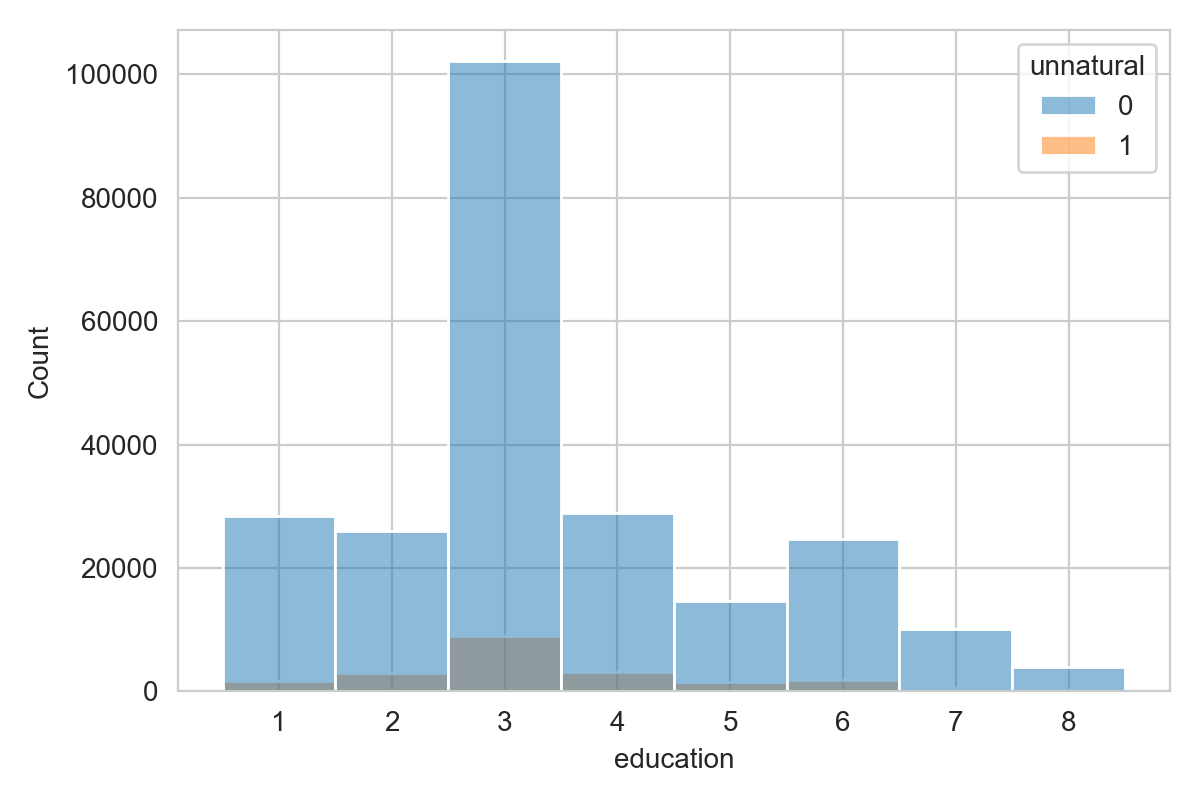

In [88]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df_sample,
            x = 'education',
            hue = 'unnatural',
#             stat = 'probability',
            bins = np.arange(1,10)-0.5
            );
fig.tight_layout()

Unnatural deaths increase as education level increases until a person has completed high-school or obtained a GED, then they began to decrease after completing some college.  

For natural deaths, there is a slight decrease from pre-high school to some high-school, but this can be explained by variable `detail_age`.

### `detail_age`

There needs to be some cleaning of the data to determine the age of the decedent, particularly in the case of the death of an infant.  I'm not sure what's going on with the feature `detail_age` or if that has been condensed down to an integer representing number of years lived.  

Note that ages which are missing are encoded as 999.  There aren't many, so we can just fill them with the median age for the particular value of `sex`.

In [57]:
df_sample.loc[df_sample.detail_age == 999].shape[0]

0

In [58]:
M_med_age = df_sample[(df_sample.detail_age != 999) & (df_sample.sex == "M")].detail_age.median()
F_med_age = df_sample[(df_sample.detail_age != 999) & (df_sample.sex == "F")].detail_age.median()

In [59]:
M_med_age, F_med_age

(73.0, 81.0)

In [60]:
df_sample.loc[(df_sample.detail_age == 999) & (df_sample.sex == "M"),'detail_age'] = M_med_age
df_sample.loc[(df_sample.detail_age == 999) & (df_sample.sex == "F"),'detail_age'] = F_med_age

# def fill_missing_age(row):
#     if row['detail_age'] == 999:
#         if row['sex'] == 'M':
#             row['detail_age'] = M_med_age
#         if row['sex'] == 'F':
#             row['detail_age'] = F_med_age
#     return row

<IPython.core.display.Javascript object>


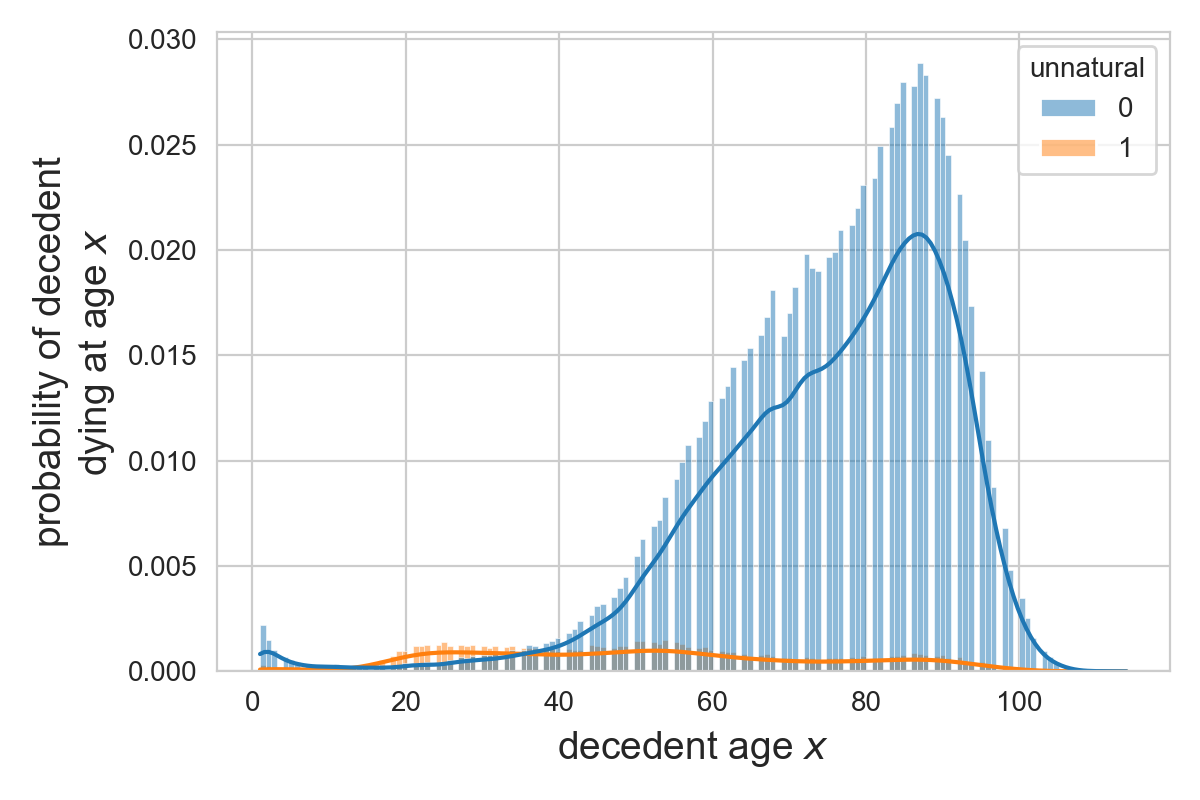

In [61]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df_sample,
            x = 'detail_age',
            hue = 'unnatural',
            stat='probability', 
            kde = True);
ax.set_xlabel('decedent age $x$', fontsize = 14)
ax.set_ylabel('probability of decedent\ndying at age $x$', fontsize = 14)
fig.tight_layout()

<IPython.core.display.Javascript object>


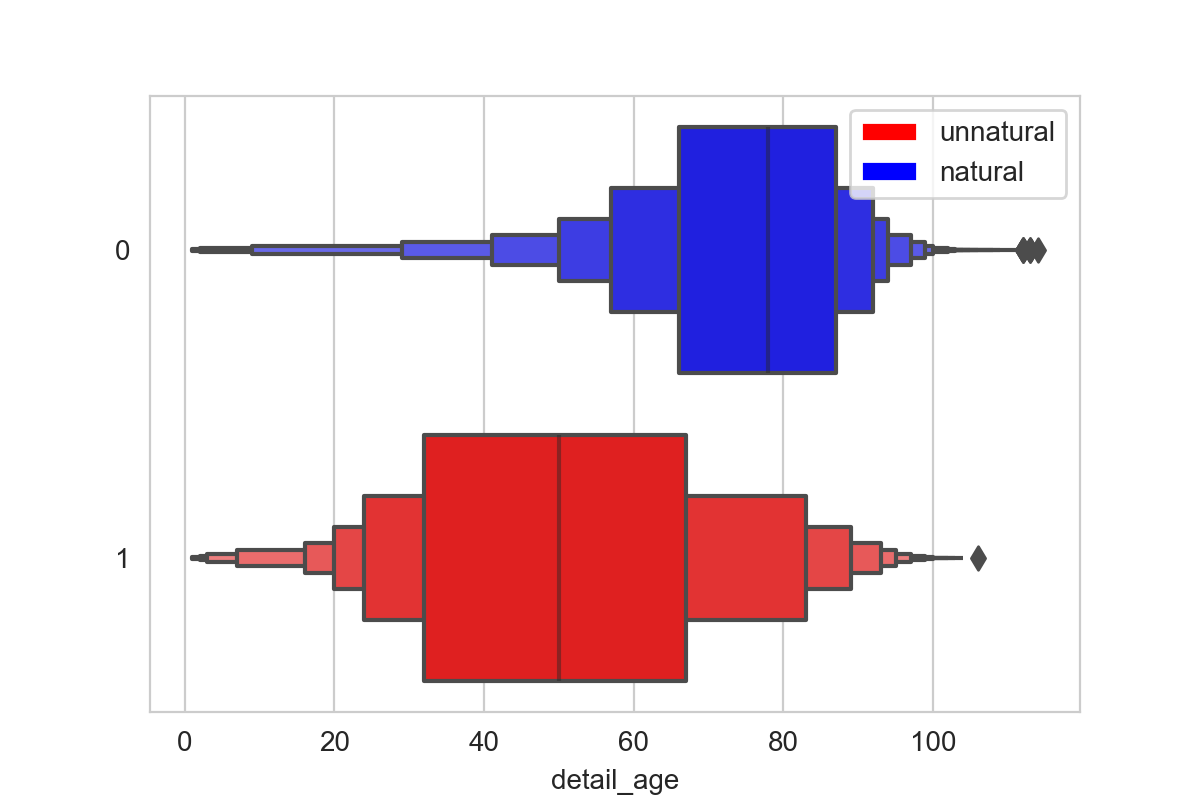

In [62]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.boxenplot(x="detail_age", y="unnatural", 
            data=df_sample, orient="h",
            palette={1:"red", 0:"blue"}, ax=ax,)

color_patches = [
    Patch(facecolor="red", label="unnatural"),
    Patch(facecolor="blue", label="natural")]
    
ax.set_ylabel('')
ax.legend(handles = color_patches);



The number of instances when the age is recorded as 1, but the child died between the time of birth and the age of 1 is tiny compared to the number of observations: about $0.25\%$ of the instances correspond to this scenario.

In [65]:
df_sample.detail_age.max()

114

In [66]:
df_sample.unnatural.unique()

array([0, 1])

<IPython.core.display.Javascript object>


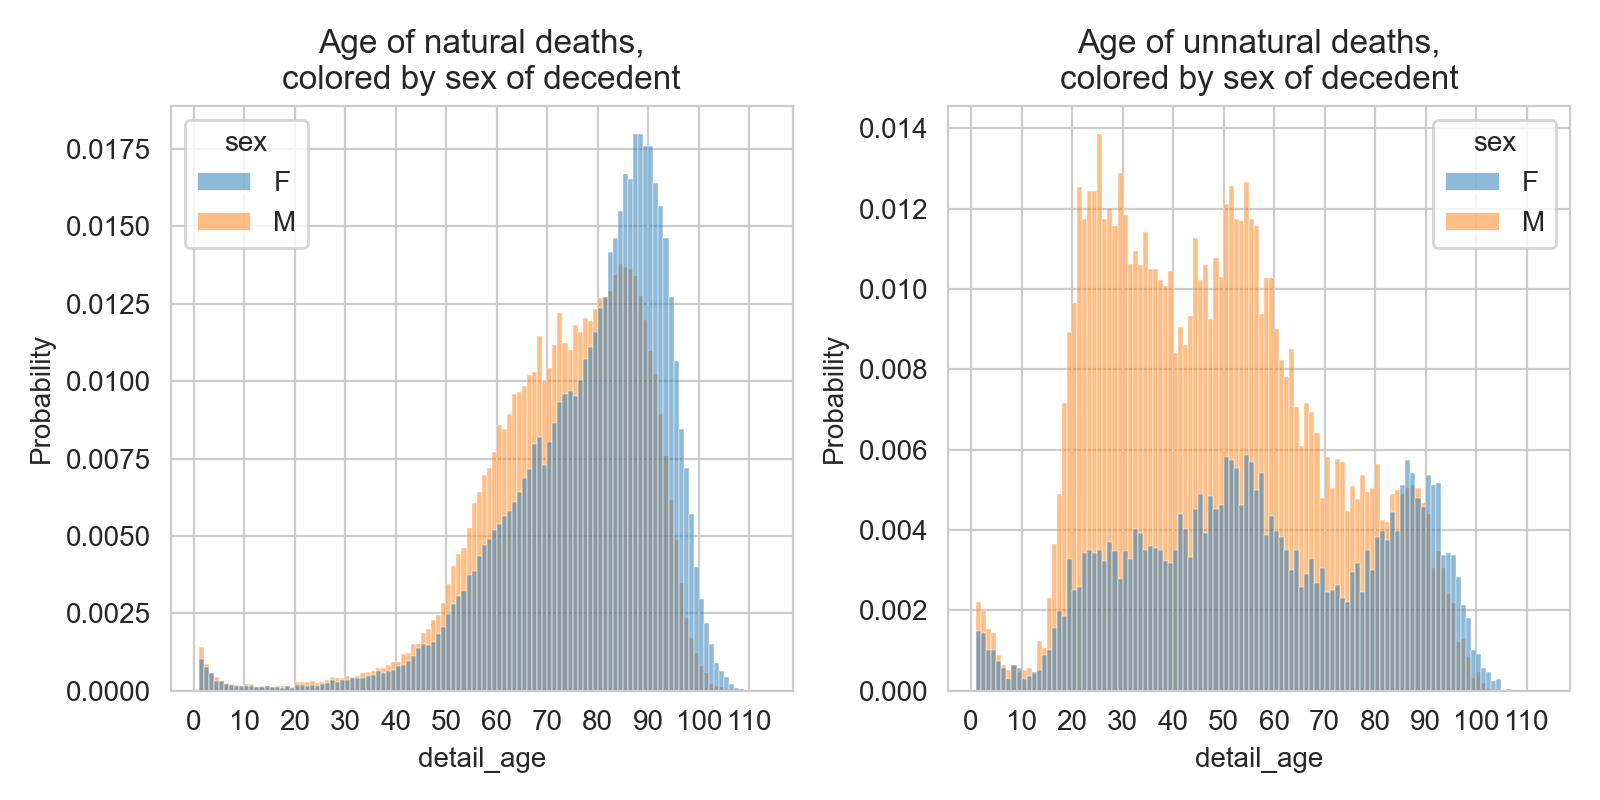

In [67]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))

#first plot is of the age distribution of natural deaths
sns.histplot(data = df_sample[df_sample.unnatural == 0],
            x = 'detail_age',
            ax = ax[0],
            hue = 'sex',
             stat = 'probability',
             hue_order = ['F','M'],
            bins = np.arange(1,df_sample.detail_age.max()))
ax[0].set_title('Age of natural deaths,\ncolored by sex of decedent')
ax[0].set_xticks(range(0,115,10))

#second plot is of the age distribution of unnatural deaths
sns.histplot(data = df_sample[df_sample['unnatural'] == 1],
            x = 'detail_age',
            ax = ax[1],
            hue = 'sex',
             stat = 'probability',
             hue_order = ["F","M"],
            bins = np.arange(1,df_sample.detail_age.max()))
ax[1].set_title('Age of unnatural deaths,\ncolored by sex of decedent')
ax[1].set_xticks(range(0,115,10))
fig.tight_layout()

#### Conclusions:
1. Different means and different skewness
2. Many outliers for the `unnatural = 0` group.
3. This makes sense -- natural deaths tend to happen later in life, while there are certainly outliers which happen early, due to childhood/adolescent disease, as well as disease in early adulthood.  Unnatural deaths are more likely to occur when a person is out in the world exposed to danger -- this more frequently happens to middle-aged adults as they go about their business and work.


A printout of the summary statistics of the distribution of `detail_age`, by `unnatural`:

In [68]:
age_group = df_sample.groupby('unnatural')

def quantile(x,q):
    return np.quantile(x,q)
age_group_agg = age_group.agg({"detail_age":[("mean",np.mean),
                             ("min",np.min), 
                             ("q_25",lambda x: quantile(x,0.25)),
                             ('median',np.median), 
                             ("q_75",lambda x: quantile(x,0.75)),
                             ('max',np.max), ]})['detail_age']
print('Summary of the feature detail_age, by unnatural:')
print('====================================================')
print(age_group_agg)

Summary of the feature detail_age, by unnatural:
                mean  min  q_25  median  q_75  max
unnatural                                         
0          75.154778    1  66.0    78.0  87.0  114
1          50.859587    1  32.0    50.0  67.0  106


### `marital_status`

<IPython.core.display.Javascript object>


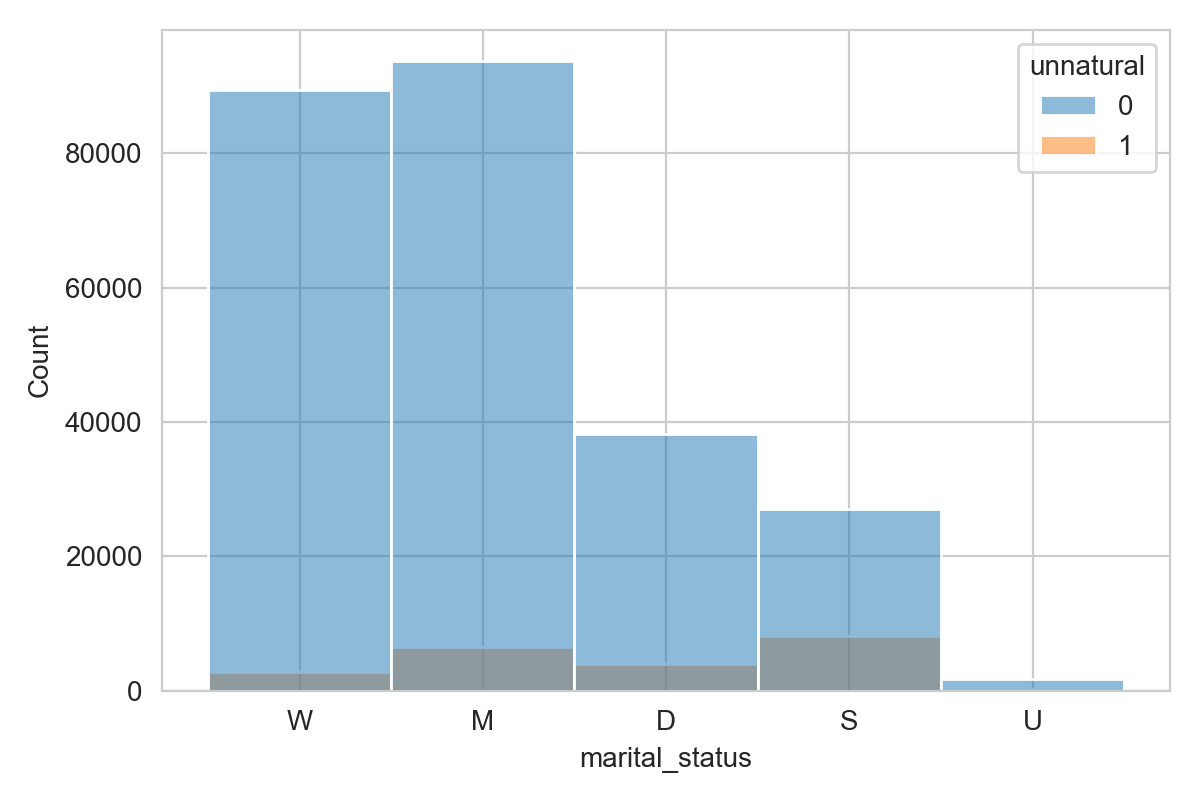

In [69]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df_sample,
            x = 'marital_status',
            hue = 'unnatural',
#             stat = 'probability',
#             bins = np.arange(1,10)-0.5
            );
fig.tight_layout()

<IPython.core.display.Javascript object>


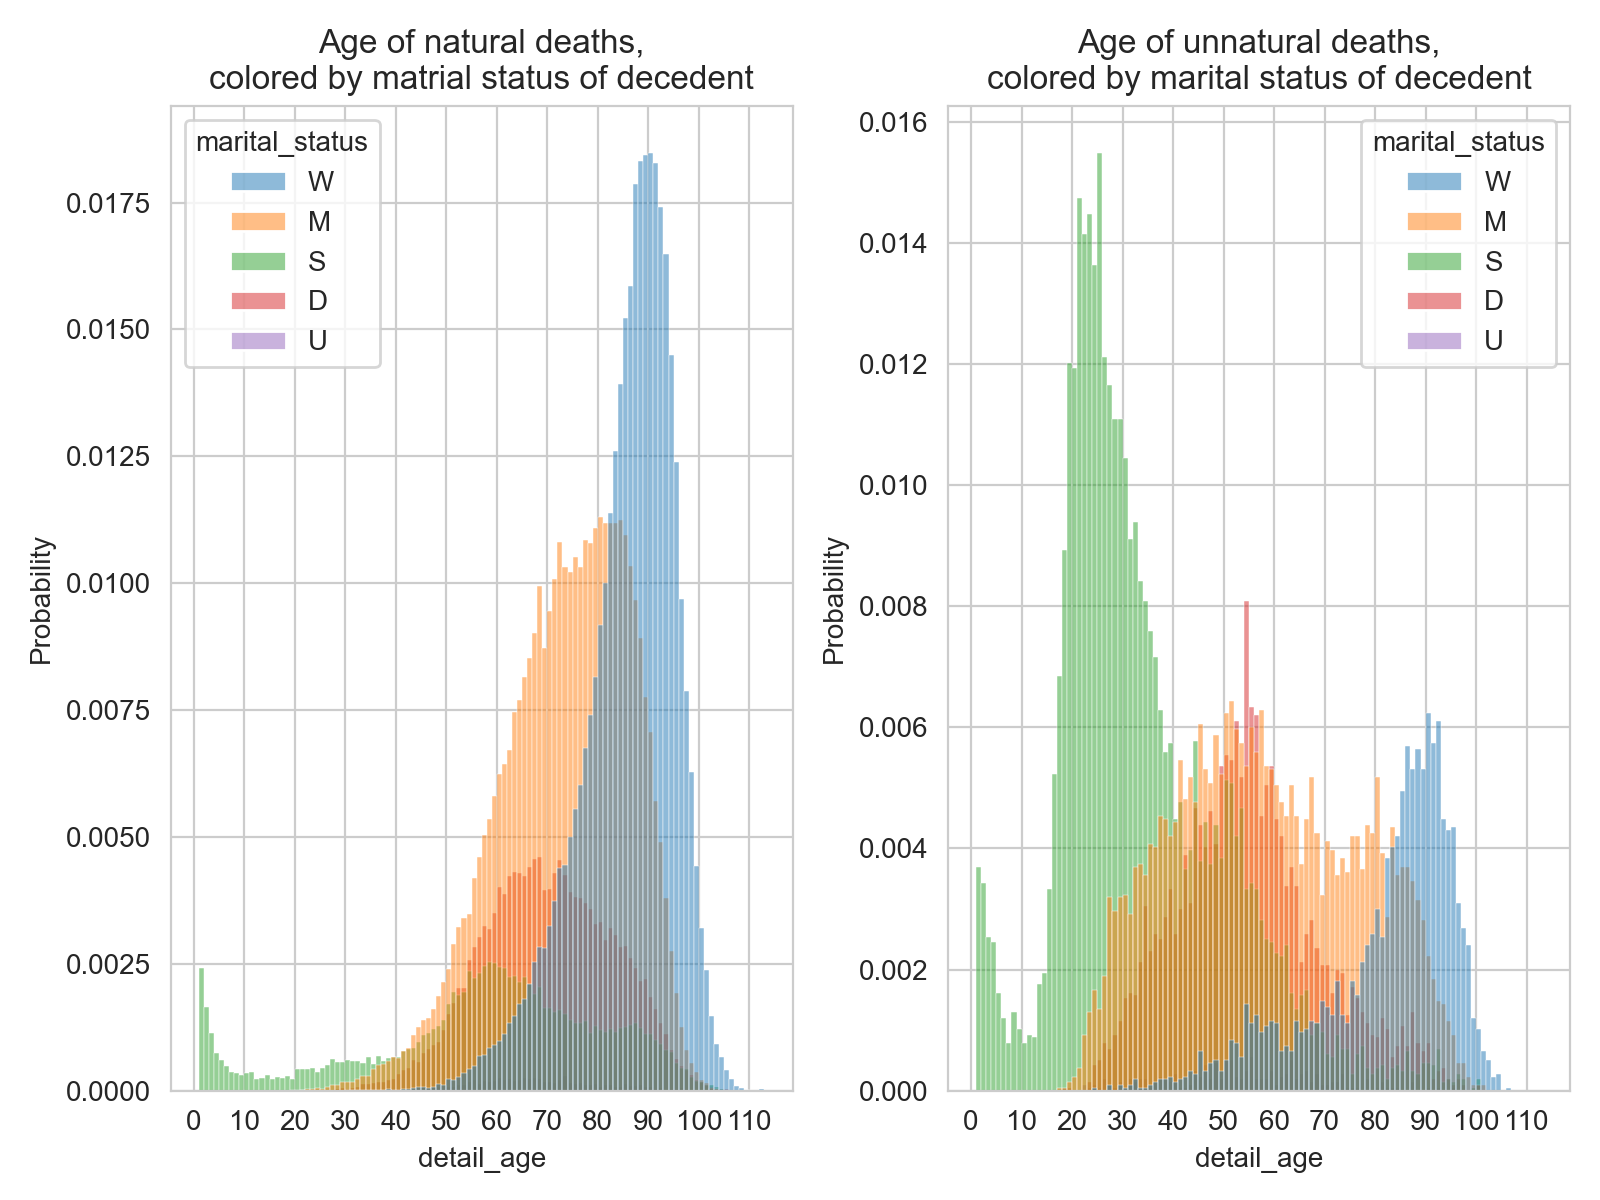

In [83]:
fig, ax = plt.subplots(1, 2, figsize = (8,6))

#first plot is of the age distribution of natural deaths
sns.histplot(data = df_sample[(df_sample.unnatural == 0)],
            x = 'detail_age',
            ax = ax[0],
            hue = 'marital_status',
             hue_order = ['W','M','S','D','U'],
             stat = 'probability',
            bins = np.arange(1,df_sample.detail_age.max()))
ax[0].set_title('Age of natural deaths,\ncolored by matrial status of decedent')
ax[0].set_xticks(range(0,115,10))

#second plot is of the age distribution of unnatural deaths
sns.histplot(data = df_sample[(df_sample.unnatural == 1)],
            x = 'detail_age',
            ax = ax[1],
            hue = 'marital_status',
             hue_order = ['W','M','S','D','U'],
             stat = 'probability',
            bins = np.arange(1,df_sample.detail_age.max()))
ax[1].set_title('Age of unnatural deaths,\ncolored by marital status of decedent')
ax[1].set_xticks(range(0,115,10))
fig.tight_layout()

### `resident_status`

<IPython.core.display.Javascript object>


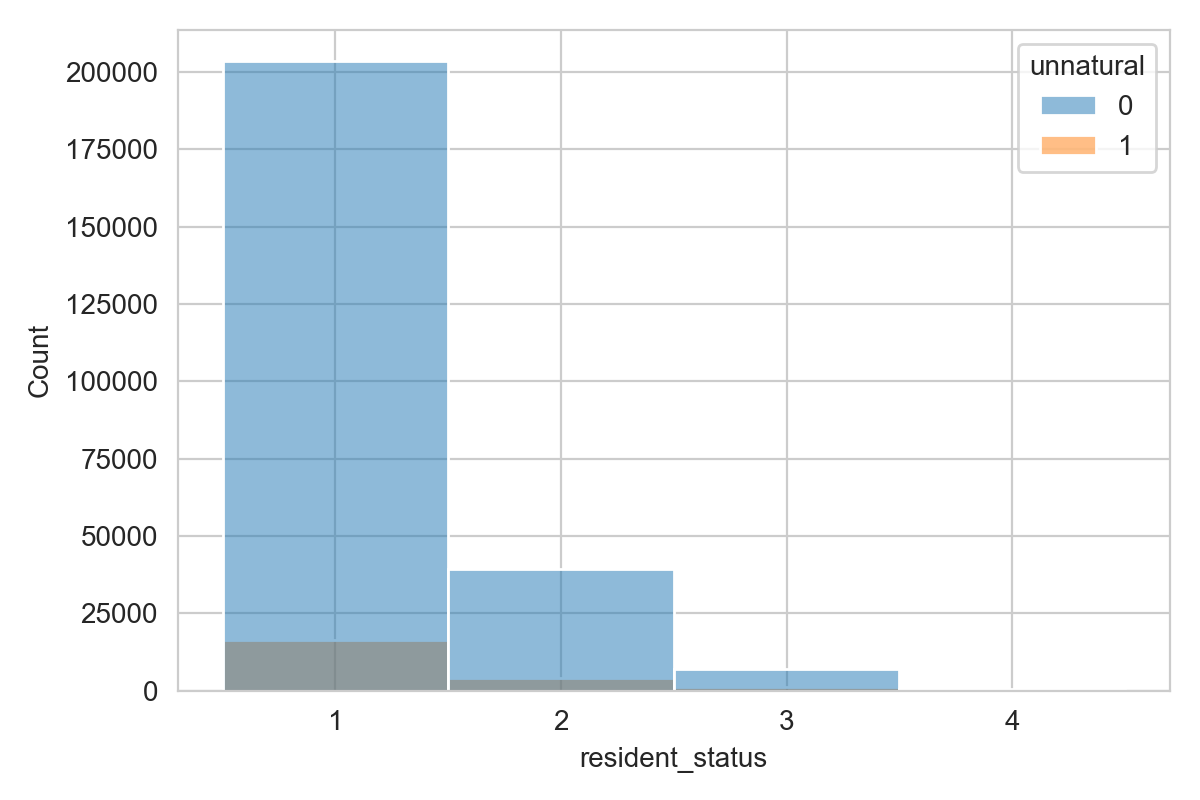

In [72]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df_sample,
            x = 'resident_status',
            hue = 'unnatural',
#             stat = 'probability',
             bins = [1,2,3,4,5]
            );
ax.set_xticks([i + 0.5 for i in range(1,5)])
ax.set_xticklabels([i for i in range(1,5)])
fig.tight_layout()

<!-- <span style= "color: red">
    11/12/22: I will return to this later... Going to check Ramazan's model first.
</span> -->
### `month_of_death`

In [75]:
# agg_month_of_death = df_sample.groupby('month_of_death').agg({'unnatural':len})

# plt.bar(x = agg_month_of_death.index,
#        height = agg_month_of_death.values.reshape(-1,))
# plt.show()

<IPython.core.display.Javascript object>


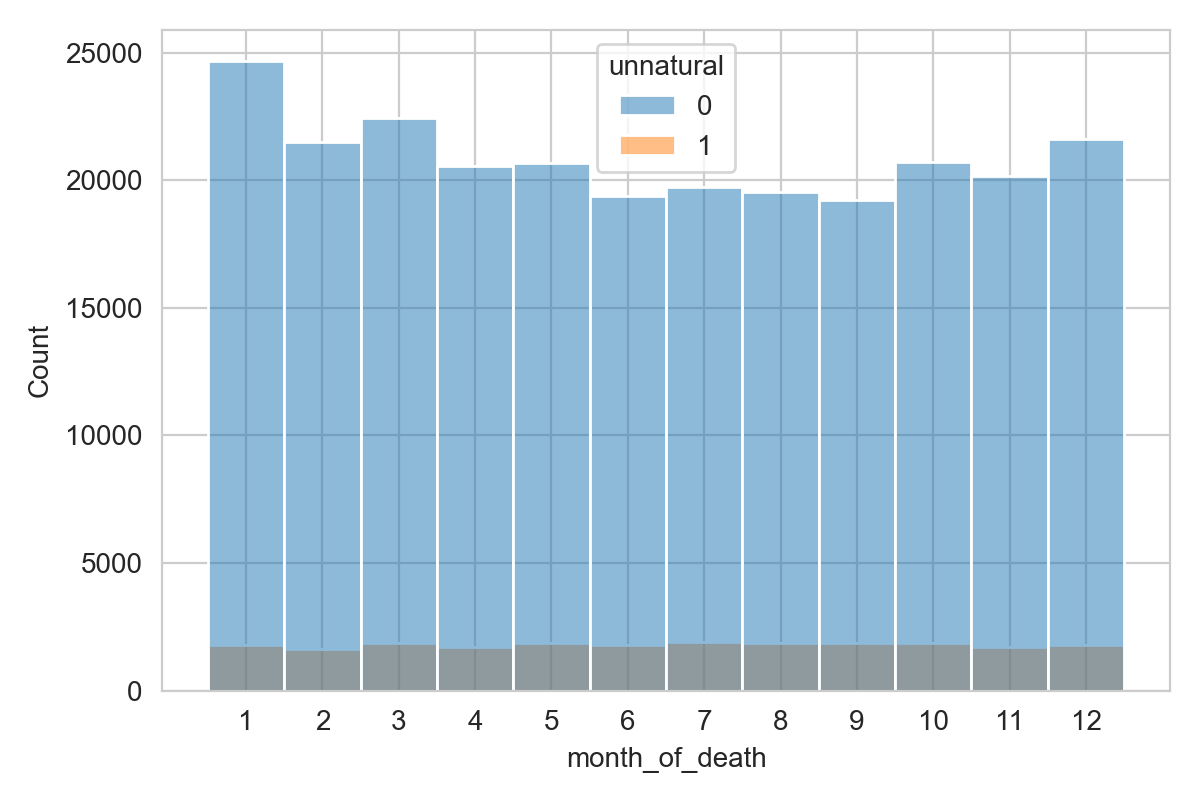

In [116]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df_sample,
            x = 'month_of_death',
            hue = 'unnatural',
#             stat = 'probability',
             bins = range(1,14)
            );
ax.set_xticks([i + 0.5 for i in range(1,13)])
ax.set_xticklabels([i for i in range(1,13)])
fig.tight_layout()

### `race`

In [117]:
race_group = df_sample.groupby('race')
unnatural_by_race = race_group.agg({'unnatural':[("total", len),("unnatural_count",sum)]})['unnatural']
unnatural_by_race['cond_prob_unnat'] = unnatural_by_race['unnatural_count']/unnatural_by_race['total']

race_dct = {key: val for key, val in zip(sorted(df_sample.race.unique()),
    ["White","Black", "American Indian", "Chinese",
     "Japanese", "Hawaiian", "Filipino","Asian Indian",
     "Korean", "Samoan", "Vietnamese", "Guamanian",
     "Other Asian\nor P.I.","Combined Other\nAsian or P.I.",
                                          "Combined Other\nAsian or P.I.",
                                          "Asian Indian"])} 

#codes 78 and 81 I am taking to be the following:
    #78: On the Combined other Asian or Pacific Islander
    #81: miswriting of 18, so Asian Indian

for r in unnatural_by_race.index:
    unnatural_by_race.loc[r,'Race'] = race_dct[r]

In [118]:
unnatural_by_race

,total,unnatural_count,cond_prob_unnat,Race
race,,,,
1,231301,18012,0.077873,White
2,31918,2860,0.089605,Black
3,1939,293,0.151109,American Indian
4,1424,86,0.060393,Chinese
5,822,39,0.047445,Japanese
6,72,6,0.083333,Hawaiian
7,1240,70,0.056452,Filipino
18,797,57,0.071518,Asian Indian
28,535,52,0.097196,Korean


Let $R$ be the random variable indicating a decedent's race, and $U$ be the random variable indicating the type of death (unnatural = 1, natural = 0).  We plot the distribution $P(U = 1|R = r)$ for each race $r\in \mathtt{race\underline{\,\,\,}dct.values}$.

<IPython.core.display.Javascript object>


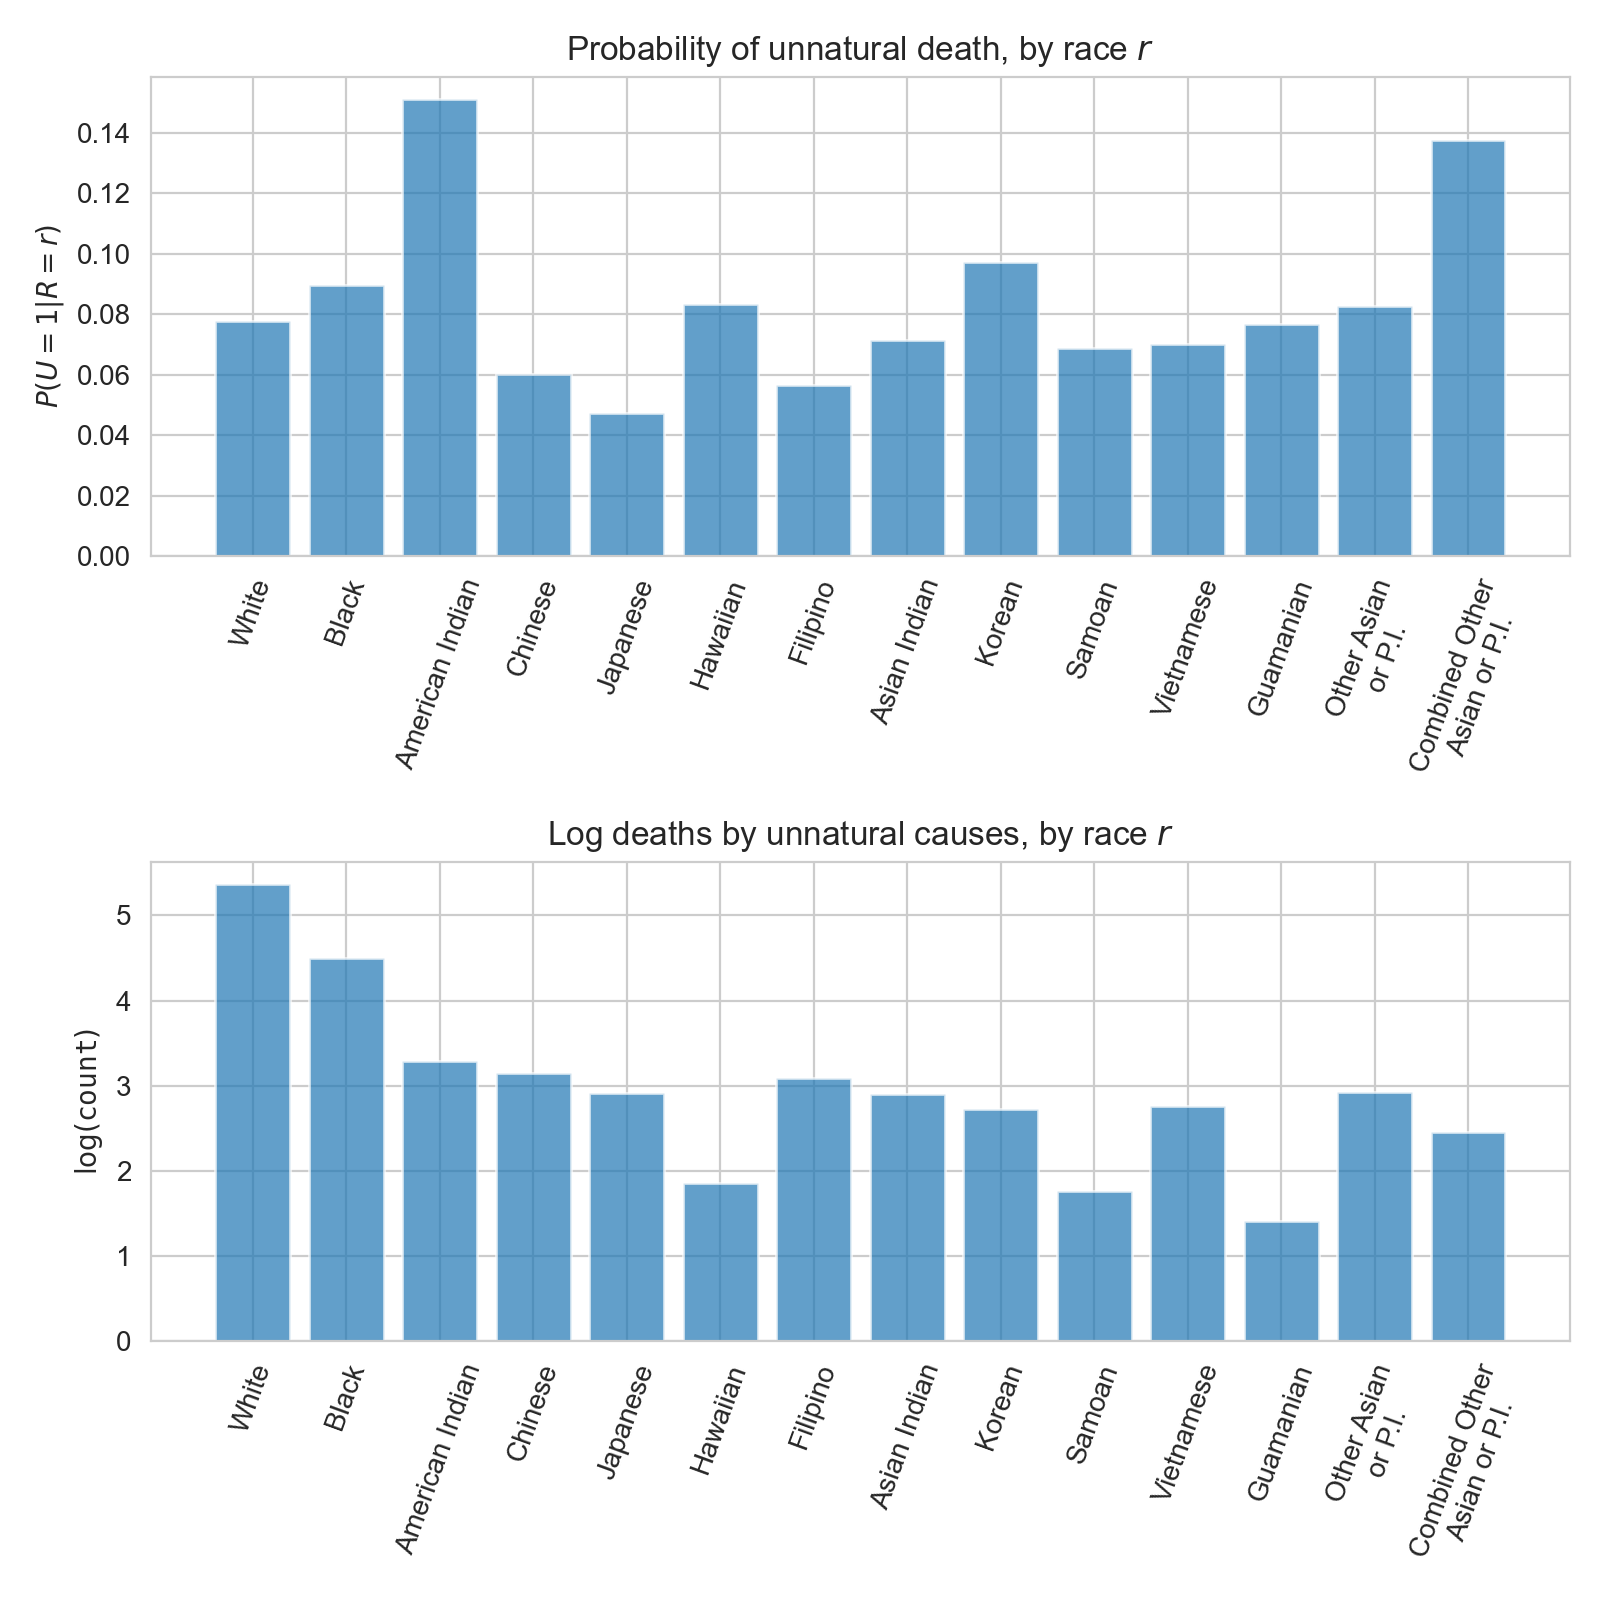

/var/folders/tw/6xd95cnj2b1dhbt719wybrbm0000gn/T/ipykernel_16604/1889775406.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(unnatural_by_race.Race, rotation = 70)
/var/folders/tw/6xd95cnj2b1dhbt719wybrbm0000gn/T/ipykernel_16604/1889775406.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(unnatural_by_race.Race, rotation = 70)


In [119]:
fig, ax = plt.subplots(2,1,figsize = (8,8))

ax[0].bar(x = unnatural_by_race.Race,
      height= unnatural_by_race.cond_prob_unnat,
      alpha = 0.7)
ax[0].set_ylabel('$P(U = 1|R = r)$')
ax[0].set_xticklabels(unnatural_by_race.Race, rotation = 70)
ax[0].set_title('Probability of unnatural death, by race $r$')

ax[1].bar(x = unnatural_by_race.Race,
          height = np.log10(unnatural_by_race.total),
          alpha = 0.7
         )
ax[1].set_ylabel('$\log(\mathtt{count})$')
ax[1].set_xticklabels(unnatural_by_race.Race, rotation = 70)
ax[1].set_title('Log deaths by unnatural causes, by race $r$')
fig.tight_layout()

# Checking Ramazan's work:
Ramazan used the features `['education_2003_revision', 'month_of_death', 'age_recode_52', 'detail_age', 'day_of_week_of_death', 'activity_code']`, but I am going to replace `education_2003_revision` with the cleaned education feature `education`.

In [120]:
R_features = ['education_2003_revision','age_recode_52','sex','resident_status','marital_status']
C_features = ['education','detail_age', 'sex', 'resident_status','marital_status']

df_sample[C_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271820 entries, 48004 to 1864535
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   education        271820 non-null  int64 
 1   detail_age       271820 non-null  int64 
 2   sex              271820 non-null  object
 3   resident_status  271820 non-null  int64 
 4   marital_status   271820 non-null  object
dtypes: int64(3), object(2)
memory usage: 20.5+ MB


In [123]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import recall_score, f1_score, confusion_matrix, classification_report, roc_curve

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [124]:
# Make a custom transformer to code the features marital_status and sex
# as well as scale the detail_age
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.StandardScaler = StandardScaler() #to scale the detail_age of decedent
        self.OneHotEncoderMS = OneHotEncoder() #to encode marital_status of decedent
        self.OneHotEncoderSex = OneHotEncoder() #to encode sex of decedent
        
    def fit(self, X, y = None):
        #fit the StandardScaler for detail_age of decedent
        self.StandardScaler.fit(X[['detail_age']])
        
        #fit the onehot for marital_status of decedent
        self.OneHotEncoderMS.fit(X[['marital_status']])
        
        #fit the onehot for sex of decedent
        self.OneHotEncoderSex.fit(X[['sex']])
        return self
        
    def transform(self, X, y = None):
        copy_X = X.copy()
        
        #scale detail_age of decedent
        copy_X['detail_age'] = self.StandardScaler.transform(copy_X[['detail_age']])
        
        #encode marital_status of decedent
        ms_encoded = pd.DataFrame(self.OneHotEncoderMS.transform(copy_X[['marital_status']]).toarray(),
                               columns = self.OneHotEncoderMS.categories_[0],
                                 index = copy_X.index)
        
        #encode sex of decedent, removing one column (sex_M = 1-sex_F)
        sex_encoded = pd.DataFrame(self.OneHotEncoderSex.transform(copy_X[['sex']]).toarray(),
                               columns = ["sex_{}".format(x) for x in self.OneHotEncoderSex.categories_[0]],
                                  index = copy_X.index)
        sex_encoded = sex_encoded.copy()[['sex_M']]
#         print((sex_encoded.index != ms_encoded.index).sum())
        
        #now merge the two encoded dataframes from above
        copy_X = copy_X.join([ms_encoded, sex_encoded])
        
        return copy_X
        

In [125]:
# make a train_test_split to df_sample
train, test = train_test_split(df_sample, test_size = 0.2, 
                              random_state = 1907, 
                              shuffle = True,
                              stratify = df_sample.unnatural)

#Now transform the ***training*** data
data_transformer = CustomTransformer()
data_transformer.fit(train)
train = data_transformer.transform(train.copy())

#And transform the test data
test = data_transformer.transform(test.copy())

In [126]:
train.columns

Index(['resident_status', 'education_1989_revision', 'education_2003_revision',
       'education_reporting_flag', 'month_of_death', 'sex', 'detail_age_type',
       'detail_age', 'age_substitution_flag', 'age_recode_52', 'age_recode_27',
       'age_recode_12', 'infant_age_recode_22',
       'place_of_death_and_decedents_status', 'marital_status',
       'day_of_week_of_death', 'current_data_year', 'injury_at_work',
       'manner_of_death', 'method_of_disposition', 'autopsy', 'activity_code',
       'place_of_injury_for_causes_w00_y34_except_y06_and_y07_',
       'icd_code_10th_revision', '358_cause_recode', '113_cause_recode',
       '130_infant_cause_recode', '39_cause_recode',
       'number_of_entity_axis_conditions', 'entity_condition_1',
       'entity_condition_2', 'entity_condition_3', 'entity_condition_4',
       'entity_condition_5', 'entity_condition_6', 'entity_condition_7',
       'entity_condition_8', 'entity_condition_9', 'entity_condition_10',
       'entity_condition

In [127]:
C_features = ['education','detail_age', 'sex', 'resident_status','marital_status']

In [ ]:
updated_ftu = ['education',
              'detail_age',
              'day_of_week_of_death',
               'D', 'M', 'S', 'U', 'W', 'sex_M']

n_splits = 10
n_models = 5
kfold = StratifiedKFold(n_splits = n_splits,
                        shuffle = True, 
                        random_state = 1907)
#axis 0: index of the kfold 
#axis 1: for the score type: recall, f1
#axis 2: for the model number
results = np.zeros((n_splits, 2, n_models))

#might use this, but probably not.
model_lst = [LogisticRegression(max_iter = 10000),
            LogisticRegression(max_iter = 10000, class_weight = 'balanced'),
            RandomForestClassifier(n_estimators = 100, max_depth = 8),
            RandomForestClassifier(n_estimators=100, max_depth=8 ,class_weight = 'balanced')]

i = 0
for tt_ix, ho_ix in kfold.split(train, train.unnatural):
    
    #make the train and holdhout sets
    train_tt, train_ho = train.iloc[tt_ix], train.iloc[ho_ix]
    
    #fit the five models
    
    #Model 0: Classify as all zeros
    all_zeros = np.zeros(train_ho.unnatural.shape[0])
    results[i,0,0] = f1_score(all_zeros, train_ho.unnatural, zero_division = 0)
    results[i,1,0] = recall_score(all_zeros, train_ho.unnatural, zero_division = 0)
    print(f'Model 0 {i}th validation \n', 
          classification_report(train_ho['unnatural'].values,
                                all_zeros),'\n')
    
    #Model 1: Logistic Regression: no weights
    lr1 = LogisticRegression(max_iter = 10000)
    lr1.fit(train_tt[updated_ftu], train_tt.unnatural)
    lr1_pred = lr1.predict(train_ho[updated_ftu])
    results[i,0,1] = f1_score(lr1_pred, train_ho.unnatural)
    results[i,1,1] = recall_score(lr1_pred, train_ho.unnatural)
    print(f'Model 1 {i}th validation \n', 
          classification_report(train_ho['unnatural'].values,
                                lr1_pred),'\n')
    
    #Model 2: Logistic Regressin: weights
    lr2 = LogisticRegression(class_weight = 'balanced')
    lr2.fit(train_tt[updated_ftu],train_tt.unnatural)
    lr2_pred = lr2.predict(train_ho[updated_ftu])
    results[i,0,2] = f1_score(lr2_pred, train_ho.unnatural)
    results[i,1,2] = recall_score(lr2_pred, train_ho.unnatural)
    print(f'Model 2 {i}th validation \n', 
          classification_report(train_ho['unnatural'].values,
                                lr2_pred),'\n')
    
    
    #Model 3: Random Forest: no weights
    rf1 = RandomForestClassifier()
    rf1.fit(train_tt[updated_ftu],train_tt.unnatural)
    rf1_pred = rf1.predict(train_ho[updated_ftu])
    results[i,0,3] = f1_score(rf1_pred, train_ho.unnatural)
    results[i,1,3] = recall_score(rf1_pred, train_ho.unnatural)
    print(f'Model 3 {i}th validation \n', 
          classification_report(train_ho['unnatural'].values,
                    rf1_pred),'\n')
    print(rf1.feature_importances_)
    
    #Model 4: Random Forest: weights
    rf2 = RandomForestClassifier(class_weight='balanced')
    rf2.fit(train_tt[updated_ftu],train_tt.unnatural)
    rf2_pred = rf2.predict(train_ho[updated_ftu])
    results[i,0,4] = f1_score(rf2_pred, train_ho.unnatural)
    results[i,1,4] = recall_score(rf2_pred, train_ho.unnatural)
    print(f'Model 4 {i}th validation \n', 
          classification_report(train_ho['unnatural'].values,
                                rf2_pred),'\n')
    print(rf2.feature_importances_)
    
    
    #Model 5
    
    
    i+= 1
    

In [ ]:
results.mean(axis= 0)

In [ ]:
df_sample[df_sample['race'] == 2].unnatural.sum()